# Nutriscore calculations #

Let's calculate the nutriscore for every recipe. Documentation for the formulas are available at the following link:


This will be done in three steps:

1) Calculating the weight of every vegetable based products in the recipes

2) Calculating the total weight of the recipe, in order to normalize every unit to a 100g serving

3) Applying formulas


In [155]:
import re
import pandas as pd
import json, csv
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [90]:
Full = pd.read_csv('data/fullTreated.csv',index_col = 0)
Full.head(8)

,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Saturated Fat,Sodium,Sugars,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C
Low-Carb Jicama Tostadas,18.0,57,0.0,7.4,18.0,1.0,18.0,0.0,3.0,225.0,...,0.0,6.0,3.0,0.0,Low-Carb Jicama Tostadas,13.2g,0.1,32IU,0.0,30.0
Best Fish Tacos,80.0,322,35.0,3.8,88.0,3.0,48.0,6.0,3.0,591.0,...,3.0,833.0,2.0,0.0,Best Fish Tacos,34.6g,9.0,1043IU,0.0,18.0
Crispy Pork Carnitas,35.0,317,89.0,0.4,5.0,2.0,23.0,10.0,267.0,371.0,...,6.0,1036.0,0.0,1.0,Crispy Pork Carnitas,2.1g,22.6,17IU,0.0,2.0
Jeannie's Vegetarian Enchiladas,376.0,626,59.0,9.6,193.0,6.0,77.0,8.0,1.0,818.0,...,15.0,1138.0,5.0,1.0,Jeannie's Vegetarian Enchiladas,67.2g,31.2,2569IU,0.0,49.0
Mexican Corn Bread Casserole,168.0,304,101.0,1.9,58.0,2.0,28.0,6.0,21.0,372.0,...,8.0,708.0,4.0,0.0,Mexican Corn Bread Casserole,21.5g,16.3,840IU,0.0,12.0
Cochinita Pibil (Mexican Pulled Pork in Annatto Sauce),56.0,422,122.0,0.9,28.0,2.0,49.0,16.0,3.0,811.0,...,9.0,1334.0,5.0,2.0,Cochinita Pibil (Mexican Pulled Pork in Annatt...,8.3g,25.6,158IU,1.0,31.0
Authentic Mexican Chili Rellenos,312.0,263,102.0,1.1,50.0,2.0,26.0,3.0,517.0,217.0,...,8.0,357.0,3.0,0.0,Authentic Mexican Chili Rellenos,17.3g,16.0,594IU,0.0,65.0
Pollo Adobado,51.0,350,129.0,1.9,32.0,2.0,61.0,29.0,5.0,706.0,...,3.0,937.0,6.0,0.0,Pollo Adobado,9.5g,12.7,3887IU,1.0,71.0


In [91]:
def ingr2dic(ingredients):
    ingredientDic = {}
    itera = 0
    for i in ingredients:
        itera = itera+1
        parsed = re.match('(\d+([\.,\/]\d+)?)\s+((g|ml|pinch|clove)\s)?', i)   #needs improvement
        if (parsed) != None:
            dic = {}

            if i.find(',')>0:
                name = i[len(parsed[0]):i.find(',')]
            else:
                name = i[len(parsed[0]):]
            dic['name']=name
            dic['unit']     = parsed[4]
            
            #Converting the '1/8 lettuce' to decimal form '0.125 lettuce'
            if re.match('\d\/\d+',parsed[1]):
                p = re.match('(\d)\/(\d)',parsed[1])
                dic['quantity']     = float(p[1])/int(p[2])
            else:    
                dic['quantity'] = parsed[1]
                
            #conversion from ounces
            parsed = re.match('\((\d+(\.\d+?)?)\s+(ounce)\)', name)
            if parsed != None:
                name = name[len(parsed[0]):]
                dic['name']=name
                dic['quantity'] = int(28.3*float(parsed[1]))*dic['quantity']
                dic['unit']     = 'g'
            
            ingredientDic[str(itera)]=dic
    return ingredientDic

In [92]:
def getVegGrams(a, ref):
    #Iterate through ingredient list, parse quantities, and detect veggetables
    #If a vegetable correspond to a list value, add it to the weight
    
    
    recipe = ingr2dic(a[ref]['Ingredients'])

    quantity = 0
    for ingredient in recipe:
        name = recipe[ingredient]['name'].lower()
       # print(name)
        for word in veg:
            if word.lower() in name:
        #if any(word.lower() in name for word in veg):
                tmpQuantity = 0
                if recipe[ingredient]['unit'] == 'g':
                    tmpQuantity = float(recipe[ingredient]['quantity'])
                else:
                    if recipe[ingredient]['unit'] == None:
                        if word.lower() in VegDic.keys():
                            tmpQuantity = float(VegDic[word.lower()])*float(recipe[ingredient]['quantity'])
                            
                        else:
                            print("Add to Dic:" + word.lower())
                            print(recipe[ingredient])
                            tmpQuantity = 60 #estimated guess
                quantity = tmpQuantity + quantity          
                #print("Detected: \t\t" + str(word.lower()) + ' : ' + str(tmpQuantity) + ' g')
                break  #avoid multiple detection
    return int(quantity)

In [93]:
with open('data/veggies.json', 'rb') as f:
        VegDic=json.load(f)
        
#reading vegies.csv
with open('data/vegies.csv', 'r') as myfile:
    r = csv.reader(myfile)
    veg = list(r)[0]

#Adding non plural forms
for i in veg:
    if i[-1]=='s':
        veg.append(i[:-1])

In [115]:
#Calculating the veggetable weights for all recipes in the dataset
Full = pd.read_csv('data/fullTreated.csv',index_col = 0)

listVeg = []
listNutri = []
listLetter = []

for index, row in Full.iterrows(): 
    jsonPath='data/'+row['Region']+'.json'
    #print(row['Reference'])
    with open(jsonPath, 'rb') as f:
        a=json.load(f)
        #print(ingr2dic(a[row['Reference']]['Ingredients']))
        #print('\n Grams of vegetables detected: ' + str(getVegGrams(a,row['Reference'])) + ' g .')
        #Full['VeggieWeight'] = getVegGrams(a,row['Reference'])
        VeggieWeight = getVegGrams(a,row['Reference'])
        listVeg.append(VeggieWeight)
        
        #quantities are normalized to a 100g basis (we consider meals weight around 400grams)
        servingRatio = 0.25
        NegPoints = int(row.Calories/(335./4.184))+int(row.Sugars/(4.5))+int(row['Saturated Fat']/(1))+int(row.Sodium/90)
        NegPoints = int(NegPoints*servingRatio)
        
        if VeggieWeight <= 120:
            fruitPoints = 0
        if VeggieWeight > 120 and VeggieWeight <= 180:
            fruitPoints = 1
        if VeggieWeight > 180 and VeggieWeight <= 240:
            fruitPoints = 2
        if VeggieWeight > 240:
            fruitPoints = 5
        PosPoints = fruitPoints + int(servingRatio*row.Protein/(1.6)) + int(servingRatio*row['Dietary Fiber']/(0.9))
        score = NegPoints - PosPoints
        listNutri.append(score)
    
        if score <= -1:
            letter = 'A'
        if score > -1 and score <= 2:
            letter = 'B'
        if score > 2 and score <= 10:
            letter = 'C'
        if score > 10 and score <= 19:
            letter = 'D'
        if score > 19:
            letter = 'E'
        listLetter.append(letter)
            
            
Full['VeggieWeight'] = listVeg
Full['NutriScore'] = listNutri
Full['NutriLetter'] = listLetter

In [116]:
Full.sort_values(by=['NutriScore'])['NutriScore']

Greek Pasta with Tomatoes and White Beans                  -8
Yam Taeng (Spicy Cucumber Salad)                           -8
Make-Ahead Vegetarian Moroccan Stew                        -8
Moo Goo Gai Pan                                            -8
Pollo Adobado                                              -8
Moroccan Lentil Soup                                       -7
Silpancho from Cochabamba, Bolivia                         -7
Cholay (Curried Chickpeas)                                 -6
Key Sir Alicha (Ethiopian Beets and Potatoes)              -6
Bhuna Gosht                                                -6
Bissara                                                    -6
Avocado and Tuna Tapas                                     -6
Lengenberg's Boiled Potatoes                               -6
Kik Wat (Ethiopian Red Lentil Stew)                        -6
Kay's Spaghetti and Lasagna Sauce                          -6
Brazilian Chicken with Coconut Milk                        -6
Spanish 

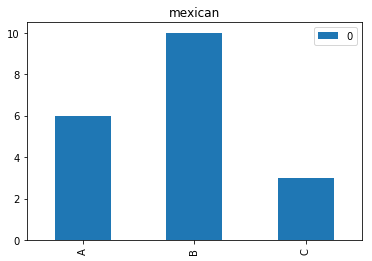

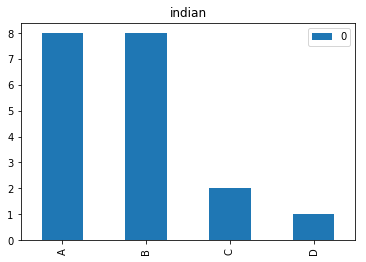

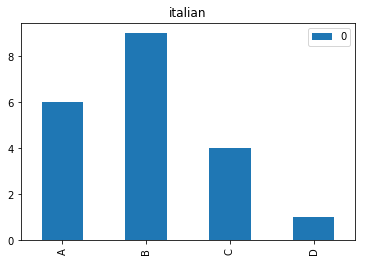

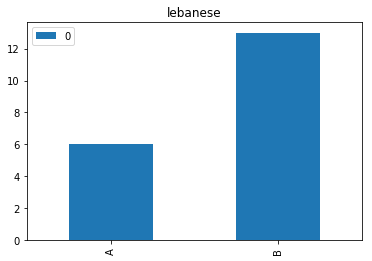

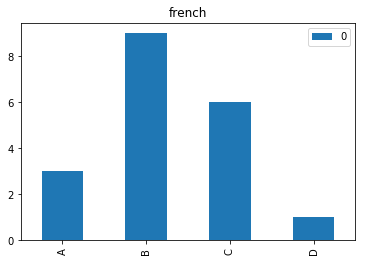

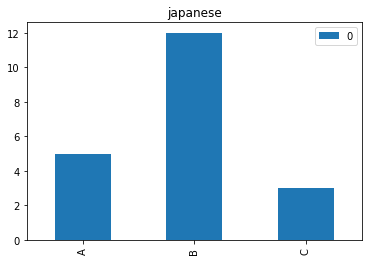

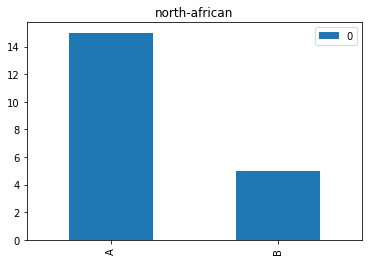

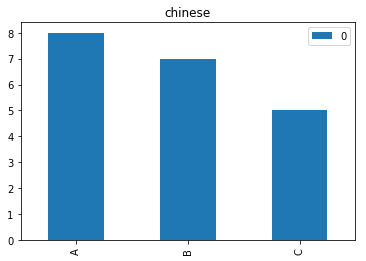

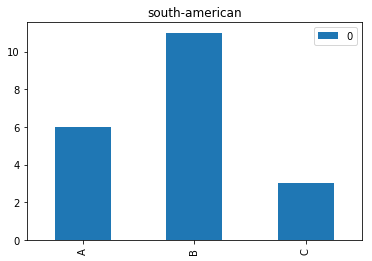

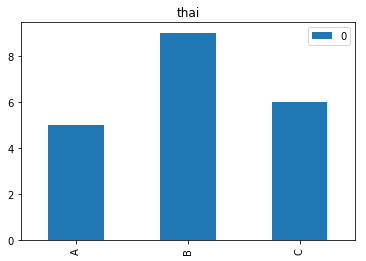

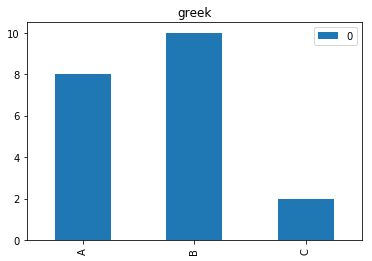

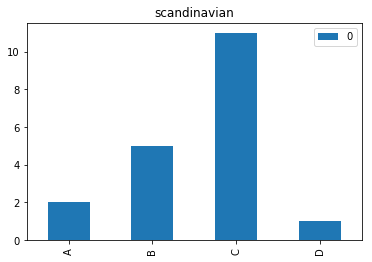

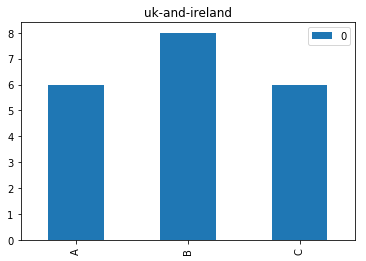

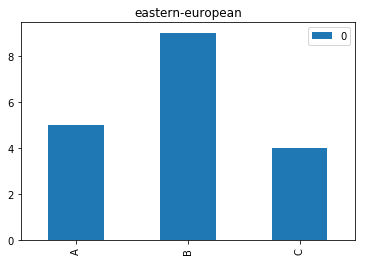

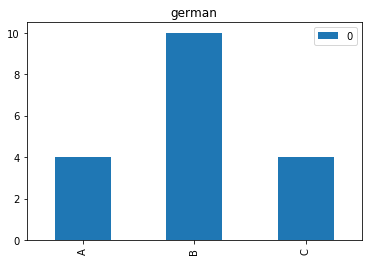

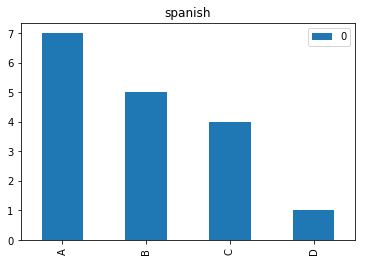

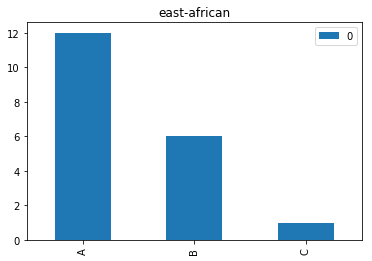

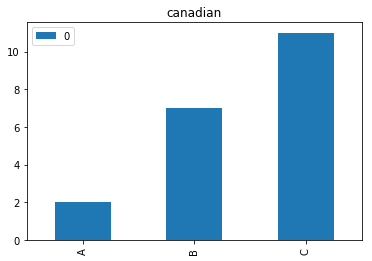

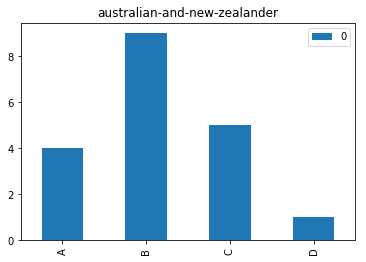

In [161]:
regions = Full['Region'].unique()
for region in regions:
    a=Full[Full['Region']==region].sort_values(by=['NutriScore'])['NutriLetter'].values
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts,orient = 'index')
    df.plot(kind='bar')
    plt.title(region)
    